# Real or Not? NLP with Disaster Tweets

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

**Acknowledgments:** this dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website [here](https://appen.com/resources/datasets/).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

In [3]:
path = '/storage/nlp-disaster-tweets'

In [4]:
df_train = pd.read_csv(path + '/train.csv')
df_test = pd.read_csv(path + '/test.csv')

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Each row in the train and test set has the following information:

- `text` of a tweet
- `keyword` from that tweet (although this may be blank!)
- `location` the tweet was sent from (may also be blank)

We are predicting whether a given tweet is about a real disaster (`target = 1`) or not (`target = 0`).

## Language model

We can combine both datasets to create a DataBunch containing all the tweet `text` data:

In [7]:
tweets = pd.DataFrame(pd.concat([df_train['text'], df_test['text']]))

In [8]:
data_lm = (TextList.from_df(tweets)
           #Getting text from concatenated dfs
            .split_by_rand_pct(0.05)
           #We randomly split and keep 5% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=48))

data_lm.save('nlp_tweet_lm')

The previous line takes time to run: we want to load the final ids quickly by using the following cell.

In [ ]:
data_lm = load_data('nlp_tweet_lm', bs=48)

In [9]:
data_lm.show_batch()

idx,text
0,orders in xxmaj california xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj
1,xxunk http : / / t.co / xxunk xxbos xxup u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horse ... http : / / t.co / xxunk via @change xxbos xxunk xxunk of annihilation xxbos xxmaj world xxmaj annihilation vs xxmaj self xxmaj transformation http : / / t.co /
2,senior year xxrep 10 ? xxbos ' xxmaj left hand side of a diamond is a xxunk shift have to attack and defend ' \n xxmaj the right xxunk no have to do that too you fucking idiot ? xxbos # xxunk xxmaj attack xxup ii xxmaj xxunk xxmaj training xxmaj machine - xxmaj sets xxmaj simulation - http : / / t.co / xxunk http : / /
3,/ xxunk xxbos xxmaj this bowl got me thinking ... xxmaj damn i 've been blazing for so damn long xxbos xxunk xxunk xxmaj he 's blazing through this game with the best xxunk skills yet . xxmaj nothing beats the xxunk xxup xxunk . xxbos xxmaj turn on your xxunk # xxunk is live on your # xxunk http : / / t.co / xxunk & & xxunk fm
4,# handbags xxmaj genuine xxmaj xxunk xxmaj xxunk xxmaj cross xxmaj body xxmaj messenger xxmaj bag xxmaj dark xxmaj oak xxmaj soft xxmaj buffalo xxmaj leather : xxunk xxmaj date : w ... http : / / t.co / xxunk xxbos xxmaj louis xxmaj vuitton xxmaj monogram xxmaj sophie xxmaj limited xxmaj edition xxmaj clutch xxmaj cross body xxmaj bag - xxmaj full read by ebay http : / /


We can now put this in a learner object with a model loaded with pretrained weights.

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


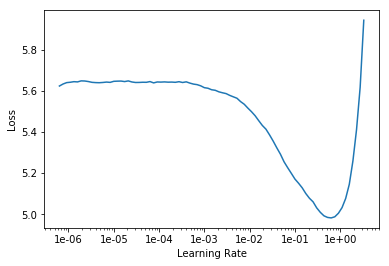

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(10, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.129880,3.244653,0.440119,00:08
1,3.447780,3.060866,0.471369,00:08
2,3.226050,3.085761,0.473988,00:08
3,3.059739,3.067354,0.478571,00:08
4,2.916474,3.066318,0.481726,00:08
5,2.734990,3.066492,0.491964,00:08
6,2.545307,3.014893,0.501429,00:08
7,2.376652,3.013293,0.502798,00:08
8,2.229757,3.006663,0.506250,00:08
9,2.130207,3.009500,0.506310,00:08


In [14]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

Let's unfreeze and retrain all the layers:

In [15]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.068118,2.998292,0.509583,00:10
1,2.049589,3.000695,0.509345,00:10
2,1.956828,2.989945,0.515119,00:10
3,1.819468,3.027352,0.521250,00:10
4,1.656476,3.102489,0.520357,00:10
5,1.508674,3.180147,0.521429,00:10
6,1.386948,3.248796,0.522500,00:10
7,1.256545,3.326176,0.519643,00:10
8,1.190285,3.348772,0.520179,00:11
9,1.155204,3.355997,0.521667,00:10


In [17]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

At this point, we have a tweet language model. So we're going to save that in order to load it into our classifier (i.e. to be a pre-trained model for the classifier). But we don't want to save the whole thing. A lot of the second half of the language model is about predicting the next word rather than about understanding the sentence written so far. 

The bit which is specifically about understanding the sentence so far is called the encoder, so we can just save that (i.e. the bit that understands the sentence rather than the bit that generates the word).

In [18]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now we're ready to create our classifier. Step one, as per usual, is to create a data bunch, and we're going to do basically exactly the same thing:

In [49]:
data_clas = (TextList.from_df(df_train, cols=['text'], vocab=data_lm.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(['target'])
             .add_test(df_test[['text']])
             .databunch(bs=48))

data_clas.save('data_clas')

In [ ]:
data_clas = load_data(path, 'data_clas', bs=48)

In [50]:
data_clas.show_batch()

text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup xxunk \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n \n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,1


We can then create a model to classify these tweets and load the encoder we saved before.

In [51]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [52]:
learn.load_encoder('fine_tuned_enc');

This time, rather than creating a language model learner, we're creating a text classifier learner.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


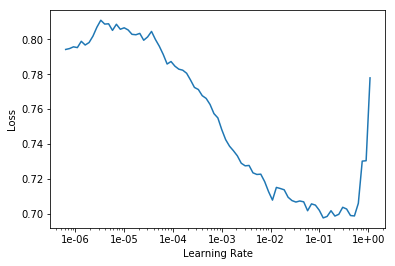

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.585178,0.514389,0.738502,00:04
1,0.539777,0.473019,0.783180,00:04
2,0.517509,0.458545,0.794350,00:04
3,0.500660,0.453910,0.800263,00:04
4,0.491919,0.460475,0.788436,00:04


In [55]:
learn.save('first')

In [ ]:
learn.load('first');

Next, we're not going to unfreeze. Instead, we'll use `freeze_to`. What that does is unfreeze the last two layers, not the whole thing. It really helps with text classification not to unfreeze the whole thing, but to unfreeze one layer at a time.

We're going to:

- unfreeze the last two layers

- train it a little bit more

- unfreeze the next layer again

- train it a little bit more

- unfreeze the whole thing

- train it a little bit more

In [56]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.500063,0.468941,0.781866,00:05
1,0.495688,0.453772,0.793036,00:05
2,0.487221,0.449327,0.798949,00:05
3,0.464840,0.445169,0.806176,00:05


In [57]:
learn.save('second')

In [29]:
learn.load('second');

In [58]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.443358,0.448583,0.797635,00:09
1,0.463496,0.457228,0.790407,00:09
2,0.433969,0.460607,0.798292,00:08
3,0.410210,0.454238,0.803548,00:08
4,0.373074,0.459888,0.804862,00:09


In [59]:
learn.save('final')

In [ ]:
learn.load('final');

## Creating submission file

We can now save our predictions and upload them to get on the Kaggle competition scoreboard.

In [60]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test,  ordered=True)
preds = preds.argmax(dim=-1)
id = df_test['id']

In [61]:
submission = pd.DataFrame({'id': id, 'target': preds})

In [62]:
submission.to_csv(path + '/submission.csv', index=False)